# QAOA performance analysis

https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20180001595.pdf

In Theorem 1, you find 
$$
〈Cuv〉(d,e,f)  =1/2+1/4sin 4βsinγ(cos^dγ+cos^eγ)−1/4sin^2βcos^{(d+e−2f)}γ(1−cos^f2γ)
$$

where u, v has number of vertices d+1, e+1 with f triangles.

## Triangle-free case

Hastings used the analysis when f=0, d=e (D=d+1 - triangle-free graph)
$$
<Cuv> = 1/2( 1 + sin(4 \beta) sin(\gamma) cos^d(\gamma))
$$

The optimal value here is when $\beta = \pi/8$ and $tan(\gamma) = 1/\sqrt{d}$

So, the optimal value:
$<Cuv> = 1/2 (1 + (1/\sqrt{D})(d/D)^{D/2}) = 1/2 +  \frac{1}{2\sqrt{D}}(1-1/D)^{D/2}$

Actually, the linked paper has a typo ($1/\sqrt{D}$ not $1/\sqrt{d}$), which is corrected by hastings.

Hastings lower-bounds delta as $.3032/\sqrt{D}$. This is because $\sqrt{(1-1/D)^D}$ tends towards $\sqrt{e^{-1}}$.

This is validated below.

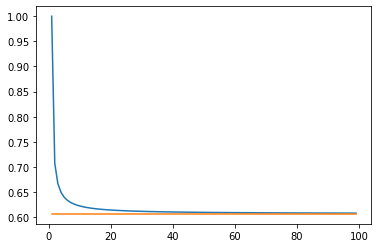

In [3]:
def sequence(D):
    """Implements sequence in triangle-free optimal Cuv value."""
    return ((D-1)/D)**((D-1)/2)

from math import e
import matplotlib.pyplot as plt
inputs = range(1, 100)
plt.plot(inputs, [sequence(i) for i in inputs])
plt.plot(inputs, [e**-0.5 for i in inputs])

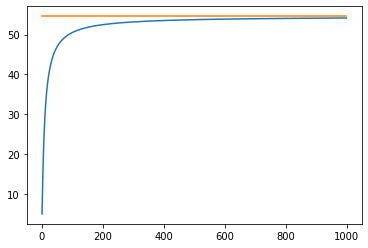

In [4]:
def generic(n, k):
    """Generic sequence (1+k/n)^n; should converge to e^k"""
    return (1 + k/n)**n

k=4
inputs = range(1, 1000)
plt.plot(inputs, [generic(i, k) for i in inputs])
plt.plot(inputs, [e**k]*len(inputs))

## With triangles

Modifying the formula to allow for triangles, but setting $d=e$:
$$
〈Cuv〉(d,f)  =1/2+1/2sin 4βsinγ(cos^dγ)−1/4sin^2βcos^{2(d−f)}γ(1−cos^f2γ)
$$

I am not initially sure how to maximize this, but I can use a grid search over $\beta$ and $\gamma$ to guess.

In [5]:
from numpy import sin, cos, linspace, pi
import numpy as np

In [48]:
def cuv_triangles(beta, gamma, d, f):
    """This implements the Cuv formula, allowing for f triangles in a d+1-regular graph."""
    return 0.5 + \
            0.5*sin(4*beta)*sin(gamma)*(cos(gamma)**d) - \
            0.25*sin(beta)*sin(beta)*(cos(gamma)**(2*d-2*f))*(1 - cos(2*gamma)**f)

In [18]:
def get_max(d, f, try_optimal_value = False):
    """This searches over beta and gamma to find the optimal value of Cuv."""
    results = []
    for beta in linspace(0, 2*pi, 128):
        results += [cuv_triangles(beta, gamma, d, f) for gamma in linspace(0, 2*pi, 128)]
        if try_optimal_value:
            # test optimal gamma choice for triangle-free graphs
            results.append(cuv_triangles(beta, np.arctan((1/d)**0.5), d, f))
    return max(results)


This search should match the optimal value closely for triangle-free graphs.

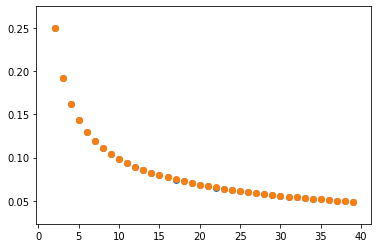

In [26]:
# This compares delta = Cuv - 1/2 from search vs the known optimal value for triangle-free graphs.
f=0
inputs = range(2, 40)
plt.scatter(inputs, [get_max(D-1, f)-0.5 for D in inputs])
plt.scatter(inputs, [sequence(D)/(2*D**0.5) for D in inputs])

How does this vary with f? It gets worse with more triangles, but not by much.

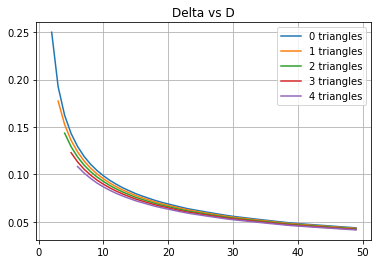

In [49]:
for f in range(5):
    inputs = range(2+f, 50)
    plt.plot(inputs, [(get_max(D-1, f)-0.5) for D in inputs], label=str(f) + " triangles")
plt.legend()
plt.title("Delta vs D")
plt.grid()

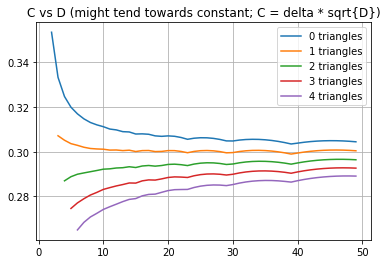

In [50]:
for f in range(5):
    inputs = range(2+f, 50)
    plt.plot(inputs, [(get_max(D-1, f)-0.5)*D**0.5 for D in inputs], label=str(f) + " triangles")
plt.legend()
plt.title("C vs D (might tend towards constant; C = delta * sqrt{D})")
plt.grid()

## todo - Optimizations
* Memoize results in cuv triangles so it only takes a long time to run once


## todo - Analytical result
* Could try to solve optimal value analytically for f=1, or f=2, etc?
* Could try to solve optimal value generally for f?

$$
〈Cuv〉(d,f)  =1/2+1/2sin 4βsinγ(cos^dγ)−1/4sin^2βcos^{2(d−f)}γ(1−cos^f2γ)
$$


## todo - Comparison with Hastings + triangles
started july 10
* it looks like Hastings does worse with many triangles, or at least takes a high D to catch up. Verify this. Why might this be?
* one triangle to one triangle, Hastings catches up by D=20-30.
* two triangles to two triangles, Hastings catches up by D=60-75.
* maybe, in limit of D, Hastings will win, but with many triangles, Hastings algorithm is not that good?
    * it makes sense. Hastings depends on the $E_{ij}$ having an impact on modifying $i$ but not $j$, or vice versa. If many neighbors are shared, it limits the impact of $E_{ij}$ being in the max cut (i.e. $i$ and $j$ being differently colored).

In [120]:
# if beta = pi/8, then the last term has this much weight compared to the triangle-free term
sin(pi/8)**2/2

0.07322330470336312

In [100]:
def test(x, d, f):
    """something to find the max of"""
    return sin(x) * cos(x)**d - .073* cos(x)**(2*d-2*f) * (1 - cos(2*x)**f)

0.15407211396280857 cot^2(gamma): 15.034609765779608
0.1503758142939567 cot^2(gamma): 15.034609765779608
0.14668016666400788 cot^2(gamma): 15.130442693719809
0.14296930832566226 cot^2(gamma): 15.130442693719809
0.13922845634952807 cot^2(gamma): 15.227156491516158
0.13544356248562403 cot^2(gamma): 15.42327015835377
0.1316021187021014 cot^2(gamma): 15.623039376023863
0.127695432523486 cot^2(gamma): 15.826555523267764
0.12371926542290256 cot^2(gamma): 16.245208598052272
0.1196756002129015 cot^2(gamma): 16.68001988102886
0.11557503917375125 cot^2(gamma): 17.364390380878994
0.11143694061245829 cot^2(gamma): 18.215310855763693
0.10728986831771681 cot^2(gamma): 19.26372604340221
0.103168733504168 cot^2(gamma): 20.551116496977574
0.09911159426621666 cot^2(gamma): 21.96746648471558


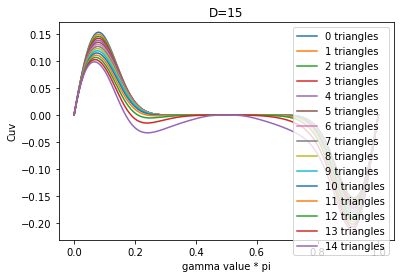

In [148]:
d=15
for f in range(d):
    inputs = np.linspace(0,pi, 4096)
    outputs = [test(x, d, f) for x in inputs]
    plt.plot(inputs/pi, outputs, label=str(f) + " triangles")
    print(max(outputs), "cot^2(gamma):", np.tan(inputs[outputs.index(max(outputs))])**-2)
plt.xlabel("gamma value * pi")
plt.ylabel("Cuv")
plt.title('D=' + str(d))
plt.legend()

Assuming Beta = pi/8, the maximum gamma value does not change by much, but it does get slightly less with more triangles.